In [122]:
# Reload and core imports
%reload_ext autoreload
%autoreload 2

# All-in-one imports
import numpy as np
from dolfin import *
from src.Optimiser import objective_function#, #spacing_constraint

from solver2 import objective_function, solve_tidal_flow_velocities_fast, update_turbine_field, setup_tidal_solver
from src.solver import (
    setup_swe_problem, setup_boundary_markers_and_bcs, solve_tidal_flow_velocities
)
from src.turbines import (
    place_turbines_random, compute_turbine_power, summarize_turbine_power, plot_turbine_layout
)
from src.plots import plot_velocity_field, compute_power_field_plot, compare_layouts
import matplotlib.pyplot as plt
from scipy.optimize import minimize, differential_evolution
#from dolfin_adjoint import *

# PETSc (quiet mode)
from petsc4py import PETSc
PETSc.Options()["ksp_monitor"] = None
PETSc.Options()["ksp_view"] = None


print("✅ Thesis SWE solver ready (v15-12)")

✅ Thesis SWE solver ready (v15-12)


In [123]:
# --- Physical and turbine parameters ---
rho = 1025.0         # Water density [kg/m³]
g = 9.81             # Gravitational acceleration [m/s²]
depth = 50.0         # Water depth [m]

C_T = 0.6             # Turbine thrust coefficient [-]
C_D = 0.0025          # Drag coefficient [-]
sigma = 5.0          # Wake Gaussian spread [m]
D = 5               # Turbine diameter
A_T = np.pi*D**2            # Turbine swept area [m²]

# --- Flow properties ---
U_inflow = 2.0       # Inflow velocity [m/s]
nu_eff = Constant(1.0)  # Effective viscosity [m²/s]
cb = 0.0025    # Bed friction coefficient [-]
viscosity = 1.0 #for now keep turbulent visc or eddy visc

#H = depth  # total depth (assuming flat bottom for now)
nu = viscosity  # viscosity coefficient

# --- Initial conditions ---
initial_condition_u = Constant((0.0, 0.0))
initial_condition_eta = Constant(0.0) # Start with no surface elevation

#----Mesh parameters----
Lx, Ly = 500.0, 400.0
Nx, Ny = 50, 35

n_turbines = 5             # number of turbines
min_spacing = 5*D     # minimum spacing between turbines [m]
#random.seed(42)             # set a fixed seed for reproducibility

#----Showing plots or not----
mesh_plot = True
turbine_position_plot = True


print(f"Initialized base parameters successfully.")

Initialized base parameters successfully.


Success! Initialized u_init with U_inflow = 2.0 m/s on a 50x35 mesh.


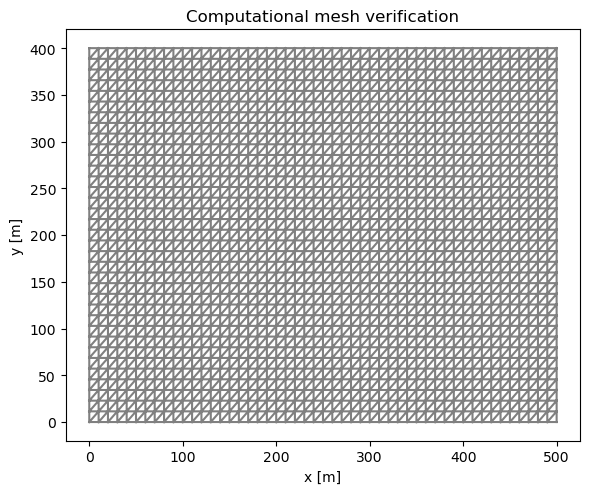

✅ Successfully placed 5 turbines after 5 attempts.
Initialized 5 turbines successfully.


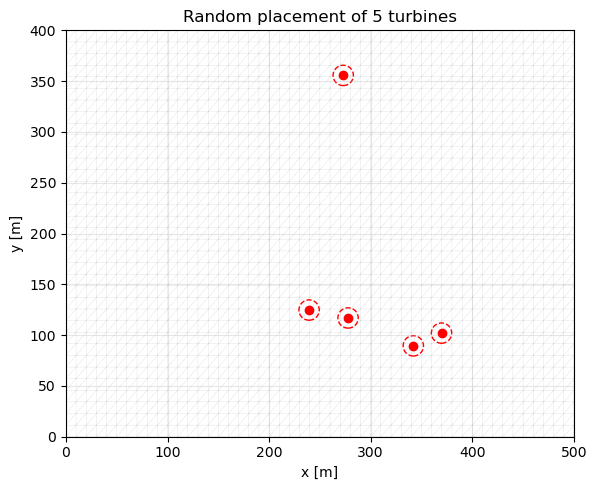

✅ Boundary markers created and BCs applied:
   - Inlet (ID=1): 2.0 m/s
   - Outflow (ID=2): marked for future use
Calling FFC just-in-time (JIT) compiler, this may take some time.
    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
Calling FFC just-in-time (JIT) compiler, this may take some time.
           Consider using the option 'quadrature_degree' to reduce the number of points
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 1.472e+00 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
      Newton iteration 1: r (abs) = 4.163e-02 (tol = 1.000e-08) r (rel) = 2.828e-02 (tol = 1.000e-07)
      Newton iteration 2: r (abs) = 4.253e-05 (tol = 1.000e-08) r (rel) = 2.889e-05 (tol = 1.000e-07)
      Newton iteration 3: r (abs) = 6.673e-11 (tol = 1.000e-08) r (rel) = 4.533e-11 (tol = 1.000e-07)
      Newton solver finished in 3 iterations and 3 linear solver iterations.
The total

In [124]:
#setting up mesh and initial turbine positions and boundary conditions and markers
mesh, W, w, u, eta, v, q, inflow, outflow, walls = setup_swe_problem(
    Lx, Ly, Nx, Ny, U_inflow, mesh_plot
)

turbine_positions = place_turbines_random(Lx, Ly, n_turbines, sigma, min_spacing)
x0 = np.array(turbine_positions).flatten() # Flatten initial turbine positions

plot_turbine_layout(mesh, turbine_positions, Lx, Ly, sigma, turbine_position_plot)
boundary_markers, bcs = setup_boundary_markers_and_bcs(mesh, W, Lx, U_inflow)

init_total_power, init_velocity = solve_tidal_flow_velocities(
    turbine_positions,
    w,
    W,
    mesh,
    bcs,
    rho,
    depth,
    nu,
    cb,
    g,
    C_T,
    A_T,
    sigma,
)

In [125]:
solver_ctx = setup_tidal_solver(mesh, W, depth, nu, cb, g)
print("Solver context built.")
bounds = [(0, Lx), (0, Ly)] * n_turbines
from scipy.optimize import differential_evolution

def objective_wrapper(x):
    """Wrapper for optimisation using cached solver."""
    return objective_function(x, solver_ctx, mesh, bcs, rho, C_T, A_T, sigma, D)
       

Solver context built.


In [126]:
# Optional: define custom initial population near your current design



init_population = np.vstack([
    x0,
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines),
    x0 + np.random.uniform(-0.05, 0.05, size=len(x0)) * np.array([Lx, Ly] * n_turbines)
])

# Run optimisation with fewer iterations for testing
result = differential_evolution(
    func=objective_wrapper,
    bounds=bounds,
    init=init_population,
    maxiter=5,        # limit iterations for speed
    popsize=5,
    workers=1,        # keep serial for FEniCS
    updating='immediate',
    disp=True,
    polish=False
)

# Extract the optimised positions
opt_positions = result.x.reshape(-1, 2)
print("Optimisation complete.\nOptimal layout:\n", opt_positions)


Calling FFC just-in-time (JIT) compiler, this may take some time.
Initial guess reset to inflow velocity field.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 2.854e+03 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
      Newton iteration 1: r (abs) = 8.565e+02 (tol = 1.000e-08) r (rel) = 3.000e-01 (tol = 1.000e-07)
      Newton iteration 2: r (abs) = 2.570e+02 (tol = 1.000e-08) r (rel) = 9.002e-02 (tol = 1.000e-07)
      Newton iteration 3: r (abs) = 7.709e+01 (tol = 1.000e-08) r (rel) = 2.701e-02 (tol = 1.000e-07)
      Newton iteration 4: r (abs) = 2.313e+01 (tol = 1.000e-08) r (rel) = 8.102e-03 (tol = 1.000e-07)
      Newton iteration 5: r (abs) = 6.938e+00 (tol = 1.000e-08) r (rel) = 2.431e-03 (tol = 1.000e-07)
      Newton iteration 6: r (abs) = 2.081e+00 (tol = 1.000e-08) r (rel) = 7.292e-04 (tol = 1.000e-07)
      Newton iteration 7: r (abs) = 6.244e-01 (tol = 1.000e-08) r (rel) = 2.188e-04 (tol = 1.000e-07)
      Newton iteration 8: r (

    No Jacobian form specified for nonlinear variational problem.
    Differentiating residual form F to obtain Jacobian J = F'.
    Solving nonlinear variational problem.
      Newton iteration 0: r (abs) = 1.644e-12 (tol = 1.000e-08) r (rel) = 1.000e+00 (tol = 1.000e-07)
      Newton solver finished in 0 iterations and 0 linear solver iterations.
The total power is 885.0 kW
Maximum theoretical power per turbine (Betz-adjusted): 135.25 kW
Momentum-sink (raw thrust) power per turbine:          193.21 kW
Max total power: 0.97 MW

Turbine performance summary:
-------------------------------------------------------
Turbine  1: Velocity = 1.94 m/s | Power = 177.62 kW
Turbine  2: Velocity = 1.92 m/s | Power = 170.64 kW
Turbine  3: Velocity = 1.95 m/s | Power = 178.71 kW
Turbine  4: Velocity = 1.95 m/s | Power = 179.36 kW
Turbine  5: Velocity = 1.95 m/s | Power = 178.64 kW
-------------------------------------------------------
Total extracted power: 0.88 MW
Fraction of park capacity: 91.61%

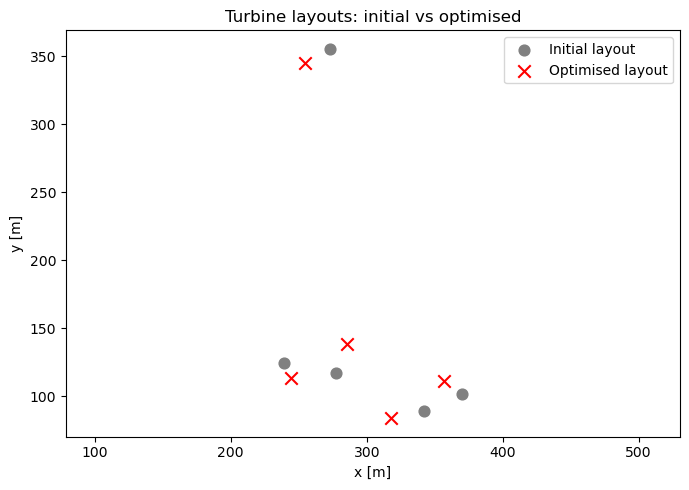

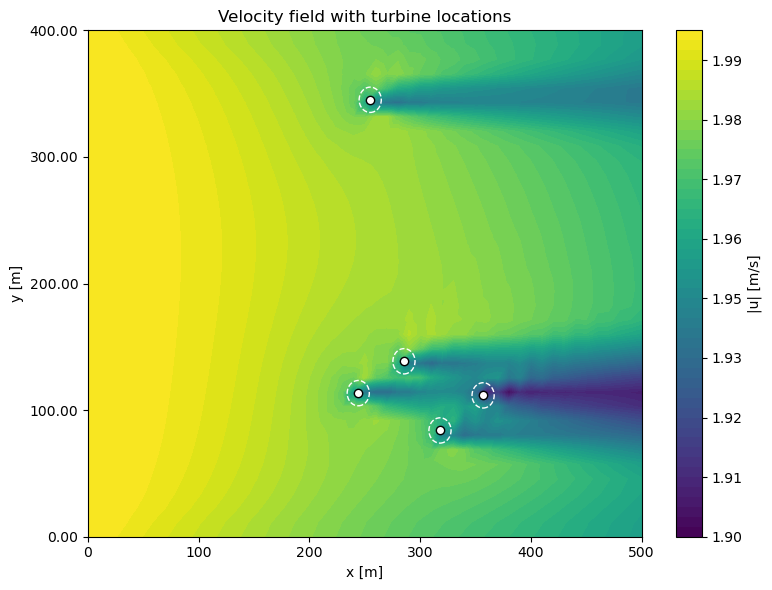

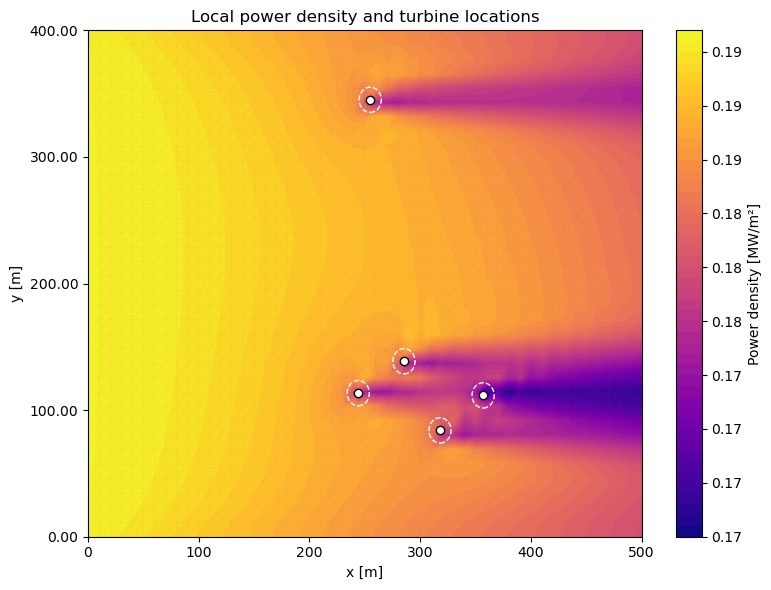

In [130]:
# --- Compute power and velocity for optimal layout ---
opt_total_power, opt_velocity = solve_tidal_flow_velocities(
    opt_positions,
    w, W, mesh, bcs,
    rho, depth, nu, cb, g,
    C_T, A_T, sigma,
)

# --- Compute per-turbine data for optimal layout ---
opt_turbine_powers, opt_turbine_velocities = compute_turbine_power(
    opt_velocity, opt_positions, rho, C_T, A_T
)

# --- Summarise results ---
opt_total_power_check, opt_max_park_power, _, _ = summarize_turbine_power(
    opt_turbine_powers, opt_turbine_velocities,
    rho, C_T, A_T, U_inflow, n_turbines
)

# --- Compute relative improvement and efficiency ---
improvement_pct = (opt_total_power_check - init_total_power) / init_total_power * 100
efficiency_pct = opt_total_power_check / opt_max_park_power * 100

# --- Print clean summary ---
print("\n========  LAYOUT OPTIMISATION SUMMARY  ========")
print(f"{'Initial total power:':35s} {init_total_power/1e3:10.2f} kW")
print(f"{'Optimised total power:':35s} {opt_total_power_check/1e3:10.2f} kW")
print(f"{'Maximum theoretical power (no wake):':35s} {opt_max_park_power/1e6:10.2f} MW")
print(f"{'Relative improvement:':35s} {improvement_pct:10.2f} %")
print(f"{'Farm efficiency:':35s} {efficiency_pct:10.2f} %")
print("===============================================\n")

# --- Combined layout comparison ---
compare_layouts(mesh, Lx, Ly, turbine_positions, opt_positions, sigma)

# --- Velocity and power field plots for optimal layout ---
plot_velocity_field(w, opt_positions, sigma)
compute_power_field_plot(C_T, rho, A_T, w, opt_positions, sigma)
